# Experiments with Marcellin's data

In [84]:
%matplotlib inline
import pylab as plt
import cPickle
a1 = cPickle.load(open('picklefile_chandwidth-1Mhz_int-25s-50s-100s_FoV-1-2-4deg_overlaps.txt'))
a2 = cPickle.load(open('picklefile_chandwidth-2Mhz_int-25s-50s-100s_FoV-1-2-4deg_overlaps.txt'))
a1.keys()

['int25s', 'bandwidth', 'int100s', 'int50s']

In [85]:
int50 = a1['int50s']
fovs = ['FoV1deg', 'FoV2deg', 'FoV4deg' ]
integrations =  ['int25s', 'int50s', 'int100s' ]
radius = int50['radius']
filters = int50['FoV1deg'].keys()
print filters

['sinc-1x1', 'sinc-3x2', 'sinc-4x3']


In [117]:
def plotfov (a, fov, bw):
    """Makes a plot for one FoV, one BW, all integrations and filters"""
    filts = filters
    for ints,color in zip(integrations, ['r-','b--','g:']):
        plt.plot(radius,a[ints]['avg']['flux'],color+'+',label='avg %s'%ints)
        for filt,ls in zip(filters, 'x*o'):
            ratio = a[ints][fov][filt]['noise'] / a[ints]['avg']['noise']
            ratio = "$\Xi=%.2f$" % ratio
            plt.plot(radius,a[ints][fov][filt]['flux'],color+ls,label='%s %s %s'%(filt, ints, ratio))
    plt.legend(loc="upper right")
    plt.title(fov+" BW "+bw)
def plotallfovs (a, bw):
    """Makes a plot for one BW, all FoVs, integrations and filters"""
    for ifov, fov in enumerate(fovs):
        plt.figure(figsize=(16,30))
        plt.subplot(len(fovs),1,ifov+1)
        plotfov(a,fov,bw)
def plotfovrel (a, fov, bw):
    """Makes a plot for one FoV, one BW, all integrations and filters, performance relative to avg"""
    filts = filters
    plt.axhline(1,ls=':k')
    for ints,color in zip(integrations, ['r-','b--','g:']):
        avg = a[ints]['avg']['flux']
        for filt,ls in zip(filters, 'x*o'):
            ratio = a[ints][fov][filt]['noise'] / a[ints]['avg']['noise']
            ratio = "$\Xi=%.2f$" % ratio
            plt.plot(radius,a[ints][fov][filt]['flux']/avg,color+ls,label='%s %s %s'%(filt, ints, ratio))
    ax = plt.gca()
#    coord = ax.transAxes.inverted().transform(ax.transData.transform((radius[-1],1)))
#    plt.legend(loc="upper right",bbox_to_anchor=coord)
    plt.legend(loc="best")
    plt.title(fov+" BW "+bw)
def plotallfovsrel (a, bw):
    """Makes a plot for one BW, all FoVs, integrations and filters"""
    for ifov, fov in enumerate(fovs):
        plt.figure(figsize=(16,30))
        plt.subplot(len(fovs),1,ifov+1)
        plotfovrel(a,fov,bw)

# 1 MHz bandwidth

At 1 MHz, we don't realize any benefits of the BDWF until we get to about 4 deg FoV. Probably because the resampling bins are "long and narrow", with the frequency direction being too boxcar-like. With FoV$\leq2$deg, the sinc smears worse than averaging.

$\Xi<1$ is impressive, but don't forget this is a snapshot. I bet for a full synthesis it'll come back to just above 1. 

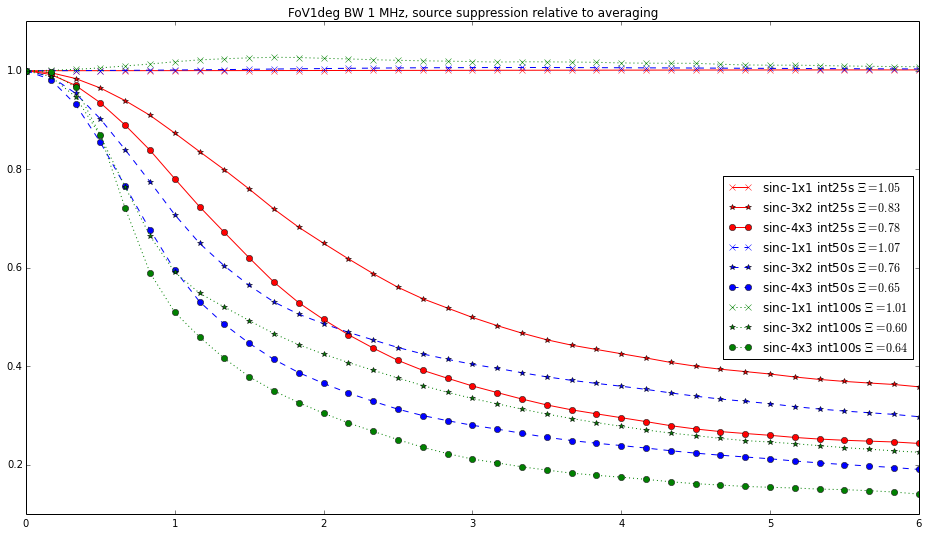

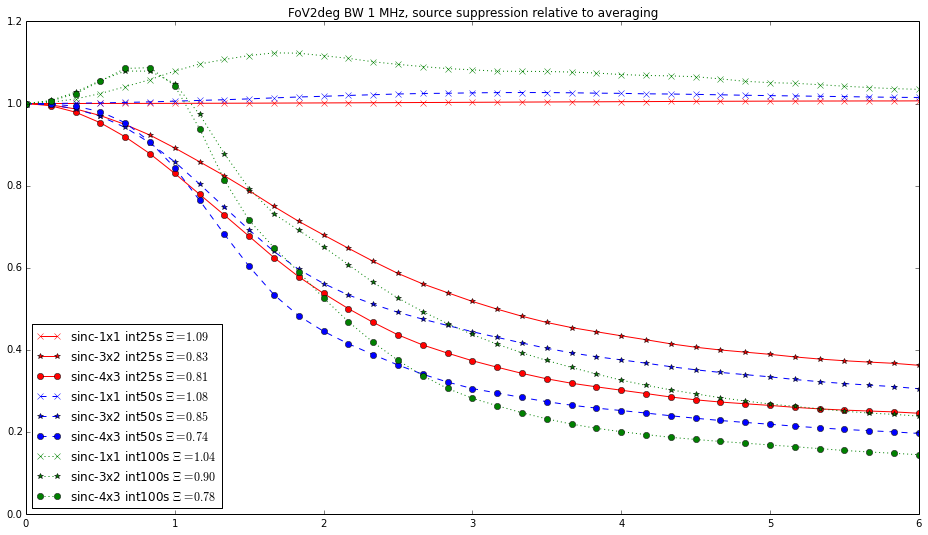

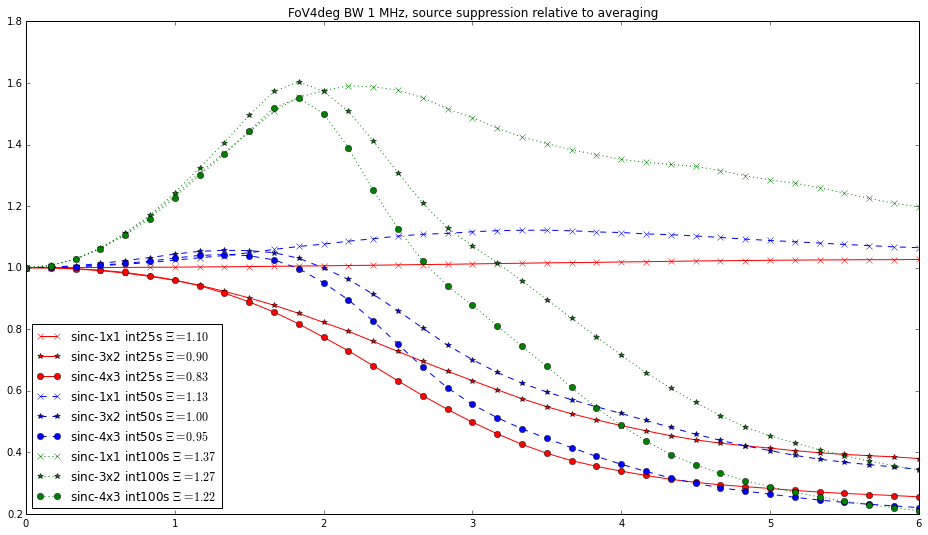

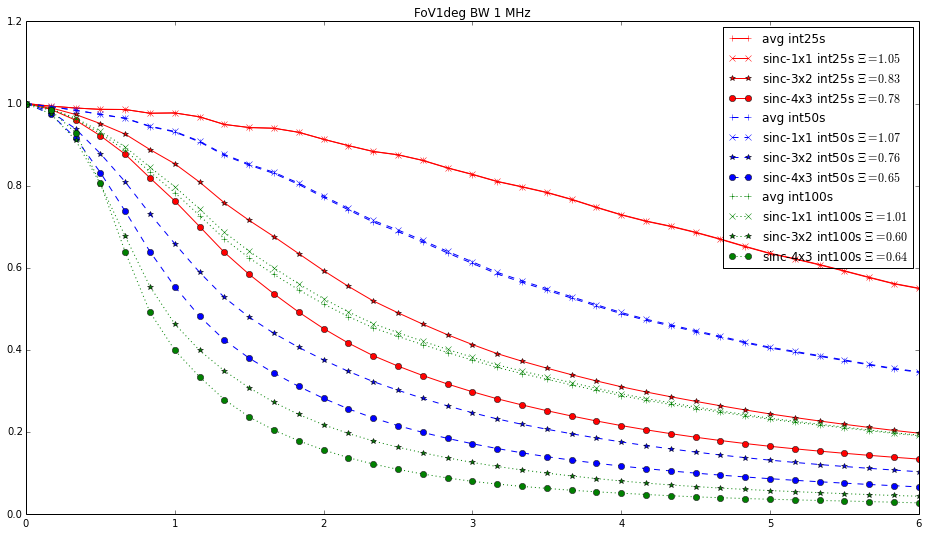

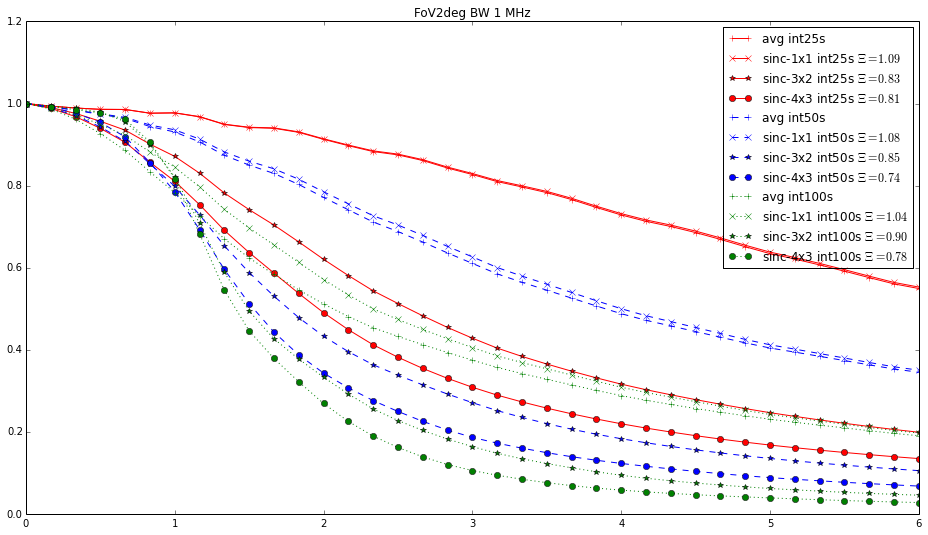

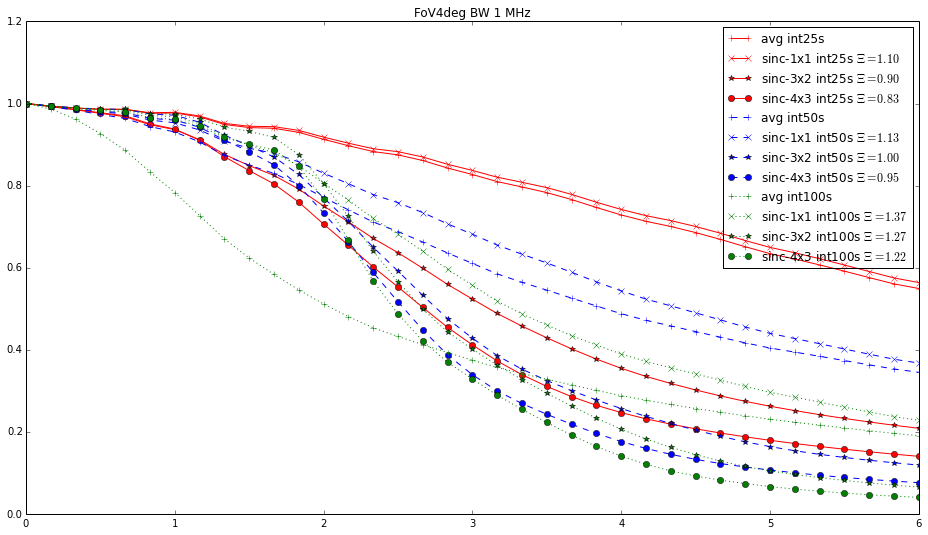

In [120]:
plotallfovsrel(a1,"1 MHz, source suppression relative to averaging")
plotallfovs(a1,"1 MHz")

# 2 MHz bandwidth
The sinc begins to kick in at FoV 2deg, but only at 100s.

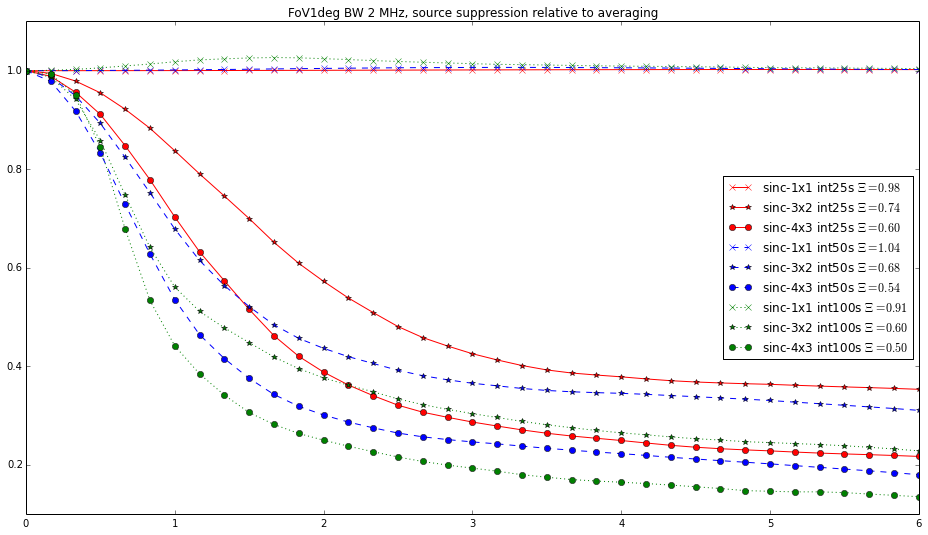

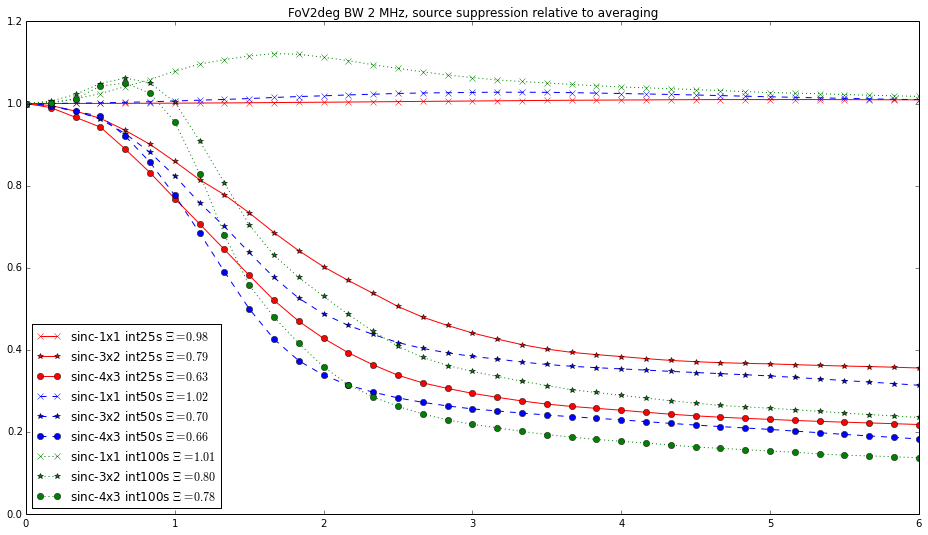

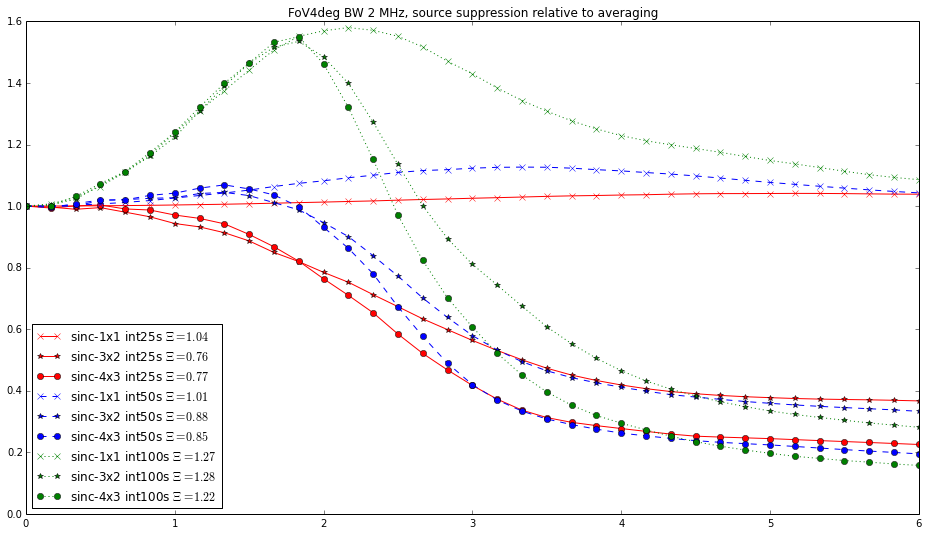

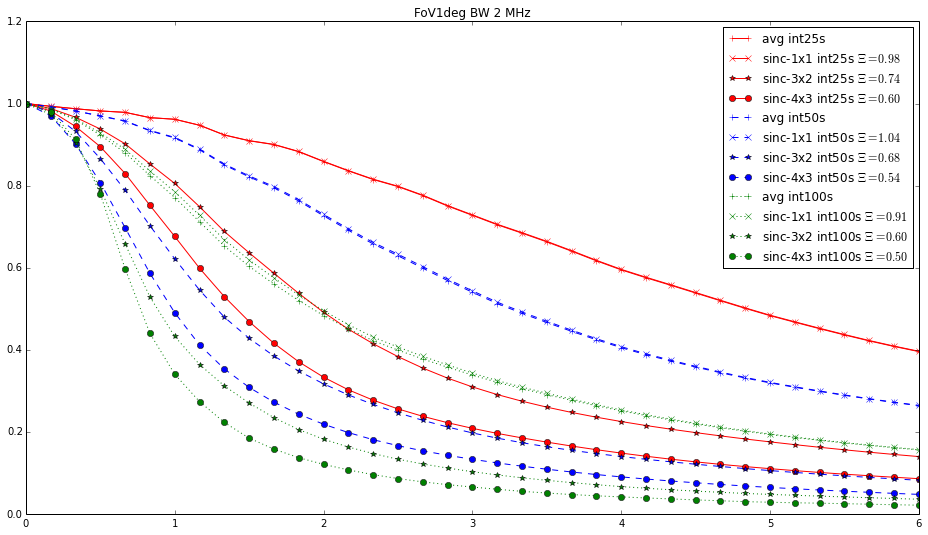

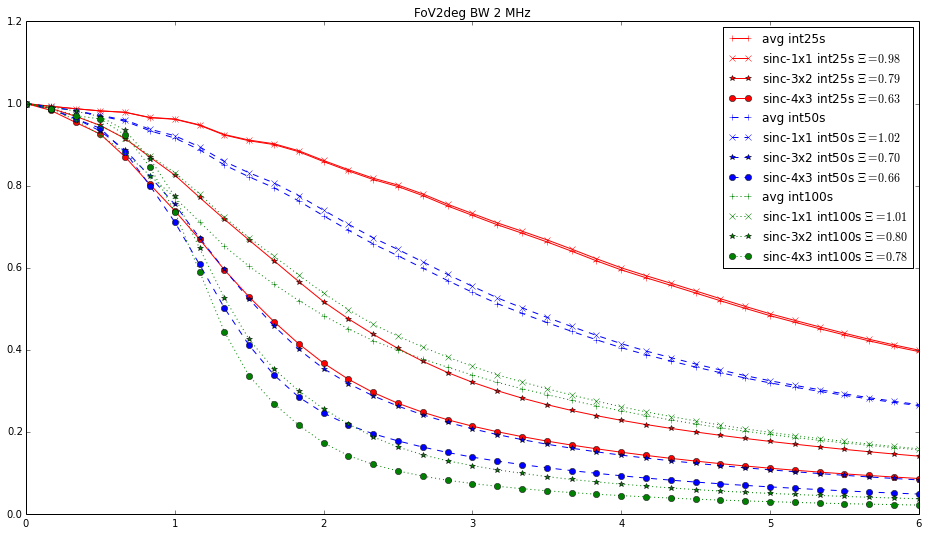

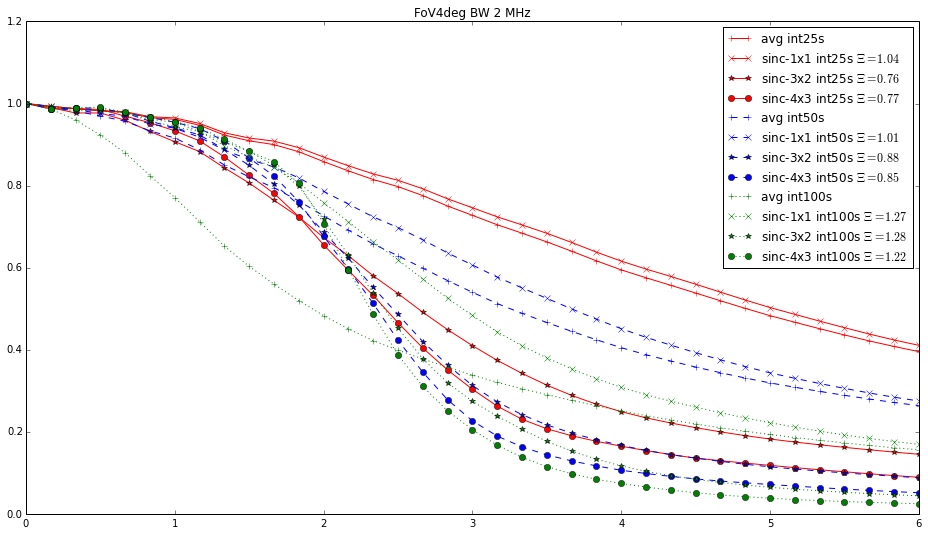

In [121]:
plotallfovsrel(a2,"2 MHz, source suppression relative to averaging")
plotallfovs(a2,"2 MHz")

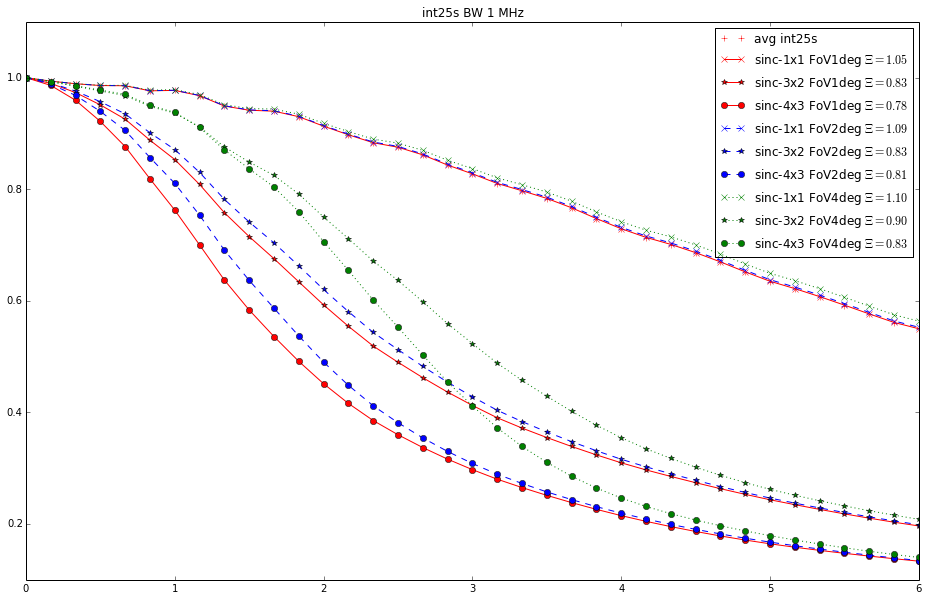

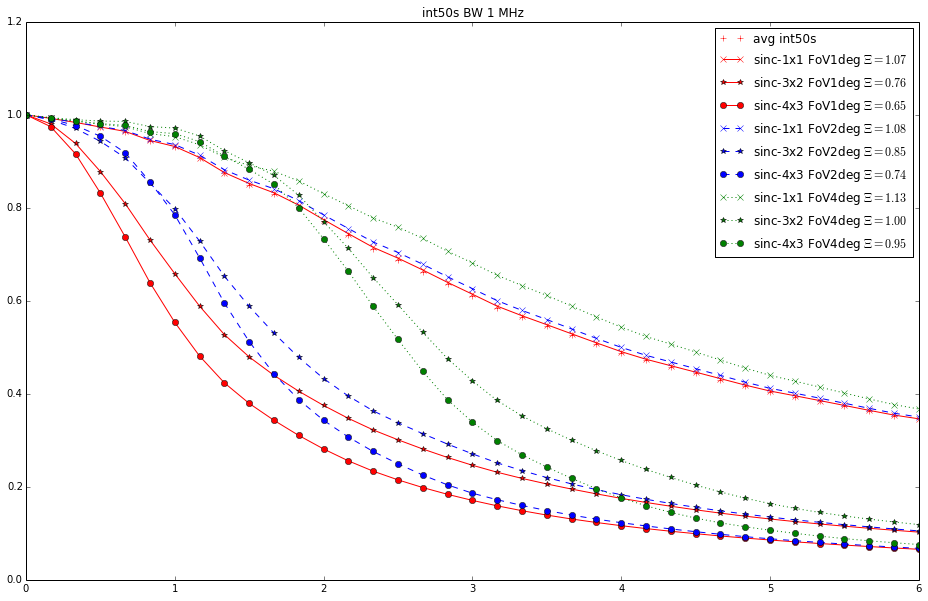

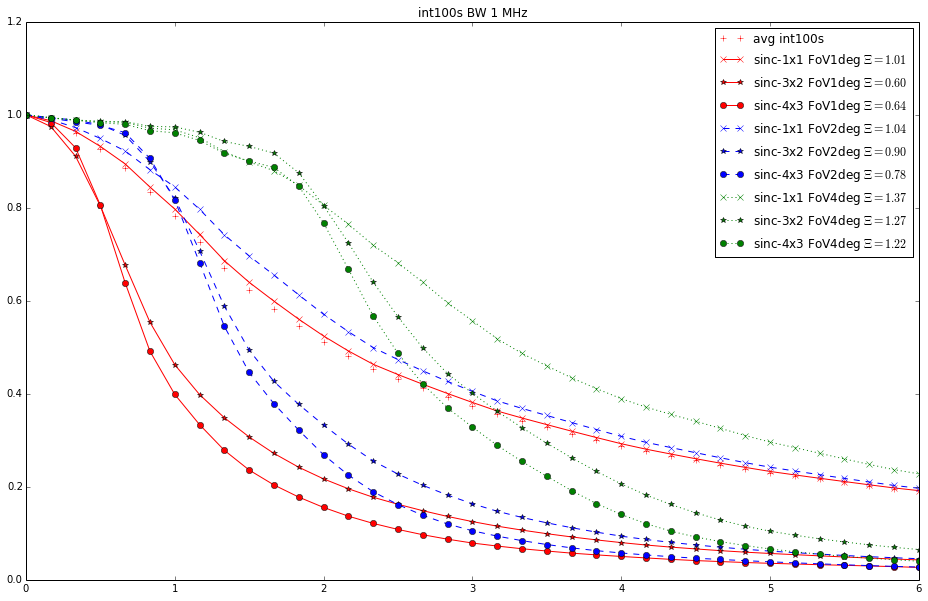

In [122]:
def plotint (ints, bw):
    filts = filters
    plt.figure(figsize=(16,10))
    plt.plot(radius,a[ints]['avg']['flux'],'r+',label='avg %s'%ints)
    for fov,color in zip(fovs, ['r-','b--','g:']):
        for filt,ls in zip(filters, 'x*o'):
            ratio = a[ints][fov][filt]['noise'] / a[ints]['avg']['noise']
            ratio = "$\Xi=%.2f$" % ratio
            plt.plot(radius,a[ints][fov][filt]['flux'],color+ls,label='%s %s %s'%(filt, fov, ratio))
    plt.legend(loc="upper right")
    plt.title(ints+" BW "+bw)
for ints in integrations:
    plotint(ints,'1 MHz')

# Remarks on freq vs time intervals
OK, we should have worked this out much earlier. There are $S=24\cdot3600=86400$ seconds in a day. In $t$ seconds of integration, a baseline $B$ with an East-West component of $B_x$ sweeps out an angle of $2\pi t/S$, and a length of $2\pi B_x t/S$.

Over a $\Delta\nu$ channel at frequency $\nu$, the effective baseline changes as $B\Delta\nu/\nu$.

So, to make the sampling bin comparable in the freq and time direction, we must have $2B_x\pi t/S = b\Delta\nu/\nu$, or $\Delta\nu=2\pi\nu (B_x/B) (t/S)$.

In [133]:
S = 24*3600
def delta_nu (t, nu=1400, bx_over_b=1):
  return 2*math.pi*nu*t*bx_over_b/S
print delta_nu(100)

10.1810873033


This gives us a very easy rule-of-thumb: at 1.4 GHz, on a fully East-West baseline, 100s is roughly 10MHz in terms of effective baseline change (i.e. effective smearing).  